In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import cv2


In [39]:
train = 'C:\\Users\\japer\\Desktop\\Image_Denoising\\Datasets\\train'
train_cleaned = 'C:\\Users\\japer\\Desktop\\Image_Denoising\\Datasets\\train_cleaned'
test = 'C:\\Users\\japer\\Desktop\\Image_Denoising\\Datasets\\test'


In [24]:
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))

 autoencoder is a type of neural network used for unsupervised learning, particularly for dimensionality reduction or feature learning. A denoising autoencoder is a variant that learns to reconstruct a clean (noise-free) input from a noisy version of it.

MaxPooling2D: Downsamples an image (makes it smaller).

UpSampling2D: Upsamples an image (makes it larger). 

In [ ]:
# Lets' define our autoencoder now
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [26]:
autoencoder = build_autoenocder()
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 420, 540, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 420, 540, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 210, 270, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 210, 270, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 105, 135, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 105, 135, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample1 (UpSampling2D)        │ (None, 210, 270, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 210, 270, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample2 (UpSampling2D)        │ (None, 420, 540, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 420, 540, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

X = []
Y = []

train_path = Path(train)
train_cleaned_path = Path(train_cleaned)

for img in train_images:
    img_path = train_path / img
    img = load_img(img_path, color_mode='grayscale', target_size=(420, 540))
    img = img_to_array(img).astype('float32') / 255.0
    X.append(img)

for img in train_labels:
    img_path = train_cleaned_path / img
    img = load_img(img_path, color_mode='grayscale', target_size=(420, 540))
    img = img_to_array(img).astype('float32') / 255.0
    Y.append(img)

X = np.array(X)
Y = np.array(Y)

print("Size of X:", X.shape)
print("Size of Y:", Y.shape)


Size of X: (144, 420, 540, 1)
Size of Y: (144, 420, 540, 1)


In [29]:
# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [33]:
# Train model
autoencoder.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - loss: 0.1693 - val_loss: 0.1742
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - loss: 0.1640 - val_loss: 0.1818
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - loss: 0.1619 - val_loss: 0.1654
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - loss: 0.1585 - val_loss: 0.1629
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 0.1520 - val_loss: 0.1593


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


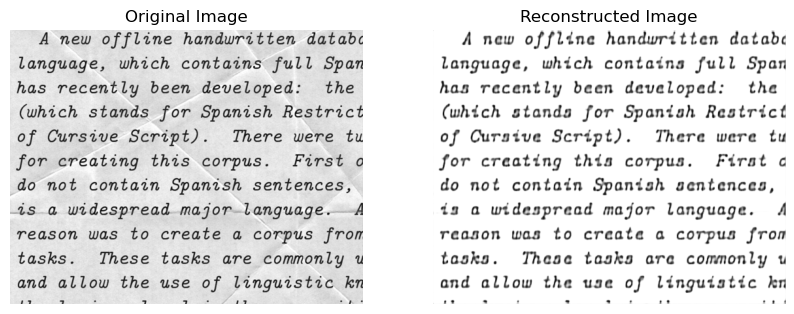

In [35]:
# Load the test image
sample_test = load_img(os.path.join(test, test_images[10]), color_mode='grayscale', target_size=(420, 540))
sample_test = img_to_array(sample_test).astype('float32') / 255.0
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the prediction from the autoencoder
predicted_label = autoencoder.predict(sample_test_img)
predicted_label = np.squeeze(predicted_label) * 255  # Rescale back to [0, 255]
predicted_label = predicted_label.astype('uint8')

# Plot the original and reconstructed images
f, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(np.squeeze(sample_test) * 255, cmap='gray')  # Original image
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(predicted_label, cmap='gray')  # Reconstructed image
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')

plt.show()


In [36]:
# Save the model
model_save_path = 'denoising_autoencoder.h5'
autoencoder.save(model_save_path)
